# Pareto/NBD Model
The Pareto/Negative-Binomial Distribution model was the first Buy-Till-You-Die (BTYD) model for estimating non-contractual customer activity over a continuous time period. First introduced by Schmittlein, et. al. in 1987 and developed further by Bruce Hardie and Peter Fader, it is frequently used as a benchmark in CLV research due to its robust performance and wide range of functionality. For detailed derivations of this model please refer to
["A Note on Deriving the Pareto/NBD Model and Related Expressions."](https://www.brucehardie.com/notes/009/pareto_nbd_derivations_2005-11-05.pdf)

In this notebook we will use Bayesian inference to fit a Pareto/NBD model in PyMC-Marketing, and compare results with the frequentist [`lifetimes`](https://github.com/CamDavidsonPilon/lifetimes) library (no longer maintained). We will also demonstrate the predictive functionality of this model - including an example with time-invariant covariates - along with planned additions.

## Setup Notebook

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
import pymc as pm
from lifetimes import ParetoNBDFitter

from pymc_marketing import clv

# Plotting configuration
az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

## Load Data

In this notebook we will be using the CDNOW sample dataset, a popular benchmarking dataset in CLV and BTYD modeling research. Refer [here](https://www.brucehardie.com/notes/026/) for more information about the dataset.

In [4]:
url_cdnow = "https://raw.githubusercontent.com/pymc-labs/pymc-marketing/main/data/cdnow_transactions.csv"

raw_data= pd.read_csv(url_cdnow)

raw_data.info()
raw_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6919 entries, 0 to 6918
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   _id         6919 non-null   int64  
 1   id          6919 non-null   int64  
 2   date        6919 non-null   int64  
 3   cds_bought  6919 non-null   int64  
 4   spent       6919 non-null   float64
dtypes: float64(1), int64(4)
memory usage: 270.4 KB


,_id,id,date,cds_bought,spent
0,4,1,19970101,2,29.33
1,4,1,19970118,2,29.73
2,4,1,19970802,1,14.96
3,4,1,19971212,2,26.48
4,21,2,19970101,3,63.34


The only requirements to model future customer behaviour with `ParetoNBDModel` are a customer identifier column, and a datetime column for each purchase. The number of CDs purchased and money spent per transaction could also be useful covariates, so we'll keep them in mind for later.

Use`rfm_summary` to aggregate data for modeling:

In [8]:
rfm_data = clv.rfm_summary(
    raw_data,
    customer_id_col = "id",
    datetime_col = "date",
    datetime_format = "%Y%m%d",
    time_unit = "W")

rfm_data.info()
rfm_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2357 entries, 0 to 2356
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   customer_id  2357 non-null   int64  
 1   frequency    2357 non-null   float64
 2   recency      2357 non-null   float64
 3   T            2357 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 73.8 KB


,customer_id,frequency,recency,T
0,1,3.0,49.0,78.0
1,2,1.0,2.0,78.0
2,3,0.0,0.0,78.0
3,4,0.0,0.0,78.0
4,5,0.0,0.0,78.0


Recall the data aggregation definitions from the [CLV Quickstart](https://www.pymc-marketing.io/en/stable/notebooks/clv/clv_quickstart.html):

- `customer_id` is an index of a unique identifiers for each customer.
- `frequency` is the number of repeat purchases that a customer has made (i.e., total number of purchases minus one).
- `recency` indicates the time period when a customer made their most recent purchase. If a customer has only made 1 purchase, recency is 0.
- `T` is a customer's "age", or the number of time periods since their first purchase.

# Model Definition
The Pareto/NBD model is based on the following assumptions for each customer:
1. Customers are active for an unobserved period of time, then become permanently inactive.
   
### Purchasing Process

2. While active, the the number of transactions made by a customer follows a Poisson process with transaction rate $\lambda$:
   $$P(X(t)=x|\lambda) = \frac{(\lambda t)^{x}e^{-\lambda t}}{x!}, x=0,1,2,...$$
   This is equivalent to assuming time between transactions is exponentially distributed with transaction rate $\lambda$:
   $$f(t_{j}-t_{j-1}| \lambda) = \lambda e^{-\lambda (t_{j} - t_{j - 1})}, \quad t_{j} \geq t_{j - 1} \geq 0$$
   Where $t$ is the time period of the $j$th purchase.
3. Heterogeneity in $\lambda$ follows a Gamma distribution with shape parameter $r$ and scale parameter $\alpha$:

    $$g(\lambda|r, \alpha) = \frac{\alpha^{r}\lambda^{r - 1}e^{-\lambda \alpha}}{\Gamma(r)}$$
### Dropout Process
5. The duration of a customer's unobserved active lifetime is exponentially distributed with dropout rate $\mu$.

6. Heterogeneity in $\mu$ also follows a Gamma distribution with shape parameter $s$ and scale parameter $\beta$::

    $$g(\mu|s, \beta) = \frac{\beta^{s}\mu^{s - 1}e^{-\mu \beta}}{\Gamma(s)}$$
7. Transaction rate $\lambda$ and time until dropout $\mu$ vary independently for each customer.

If we take the expectation across the distributions of $\lambda$ and $\mu$, we can derive a likelihood function to estimate parameters $r$, $\alpha$, $s$, and $\beta$ across the customer population. For more details on the `ParetoNBD` likelihood please refer to the [docs](https://www.pymc-marketing.io/en/stable/api/generated/pymc_marketing.clv.distributions.ParetoNBD.html#pymc_marketing.clv.distributions.ParetoNBD).

# Model Fitting

## `lifetimes` Benchmark Model

Let's time travel back to July 2020 and use the old `lifetimes` library to fit a Pareto/NBD model with Maximum Likelihood Estimation (MLE). The `Nelder-Mead` optimizer from `scipy.optimize` is ran under the hood to estimate scalar values for $r$, $\alpha$, $s$, and $\beta$.

In [9]:
freq = rfm_data["frequency"].values
rec = rfm_data["recency"].values
T = rfm_data["T"].values

pnbd_lt = ParetoNBDFitter()
pnbd_lt.fit(freq, rec, T)
pnbd_lt.params_.sort_index()

alpha    15.602799
beta     13.674880
r         0.610785
s         0.445090
dtype: float64

The Bayesian equivalent of MLE is Maximum a Posteriori(MAP), in which the returned scalar values are regularized with priors during estimation.

A "Flat" prior indicates the user is agnostic, holding no prior beliefs or assumptions about the data. $r$, $\alpha$, $s$, and $\beta$ must also be positive values, so let's configure our Bayesian `ParetoNBDModel` with `HalfFlat` priors:

In [10]:
flat_config = {
    "r_prior": {"dist": "HalfFlat", "kwargs": {}},
    "alpha_prior": {"dist": "HalfFlat", "kwargs": {}},
    "s_prior": {"dist": "HalfFlat", "kwargs": {}},
    "beta_prior": {"dist": "HalfFlat", "kwargs": {}},
    }

pnbd_pymc = clv.ParetoNBDModel(data=rfm_data, model_config=flat_config)

Build the model to view the choice of Priors used for modeling:

In [11]:
pnbd_pymc.build_model() #optional step
print(pnbd_pymc)

Pareto/NBD
                r ~ HalfFlat()
            alpha ~ HalfFlat()
                s ~ HalfFlat()
             beta ~ HalfFlat()
recency_frequency ~ ParetoNBD(r, alpha, s, beta, <constant>)


Note it is not necessary to build a model prior to modeling.

Now let's fit our `ParetoNBDModel` with MAP.

In [13]:
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

idata_map = pnbd_pymc.fit(fit_method='map')

MAP ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% 0:01:14 logp = -16,483, ||grad|| = 26.539

For MAP fitting `pymc-marketing` uses the `L_BGFS-B` optimizer from `scipy.optimize`, a faster and more stable alternative to `Nelder-Mead`.

In [16]:
flat_fit = pnbd_pymc.fit_summary()
print(flat_fit)

alpha    15.602
beta     13.674
r         0.611
s         0.445
Name: value, dtype: float64


Model parameter estimations are equivalent between the frequentist MLE fit from `lifetimes`, and a Bayesian `pymc-marketing` model fitted with flat priors!

Recall $r$, $\alpha$, $s$, and $\beta$ represent the shape and scale parameters for the population transaction rate $\lambda$ and time until dropout $\mu$ distributions, respectively. We can now estimate the mean and variance of $\lambda$ and time until dropout $\mu$:

In [18]:
# extract model parameters
r = flat_fit["r"] # shape parameter for purchase rate
alpha = flat_fit["alpha"] # scale parameter for purchase rate
s = flat_fit["s"] # shape parameter for dropout
beta = flat_fit["beta"] # scale parameter for dropout

purchase_mean = round(r * alpha,2)
purchase_var = round(r * (alpha**2),2)

dropout_mean = round(s * beta,2)
dropout_var = round(s * (beta**2),2)

print(f"Average time between transactions: {purchase_mean} weeks")
print(f"Variance of time between transactions: {purchase_var} weeks")
print(f"Average time customers are active: {dropout_var} weeks")
print(f"Variance of time customers are active: {dropout_var} weeks")

Average time between transactions: 9.53 weeks
Variance of time between transactions: 148.73 weeks
Average time customers are active: 83.21 weeks
Variance of time customers are active: 83.21 weeks


These estimates can be difficult to interpret
We can also plot these distributions:

Sampling ... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

Tail of Distribution: 0.14 weeks an active customer
Peak of Distribution: 83.33 weeks an active customer


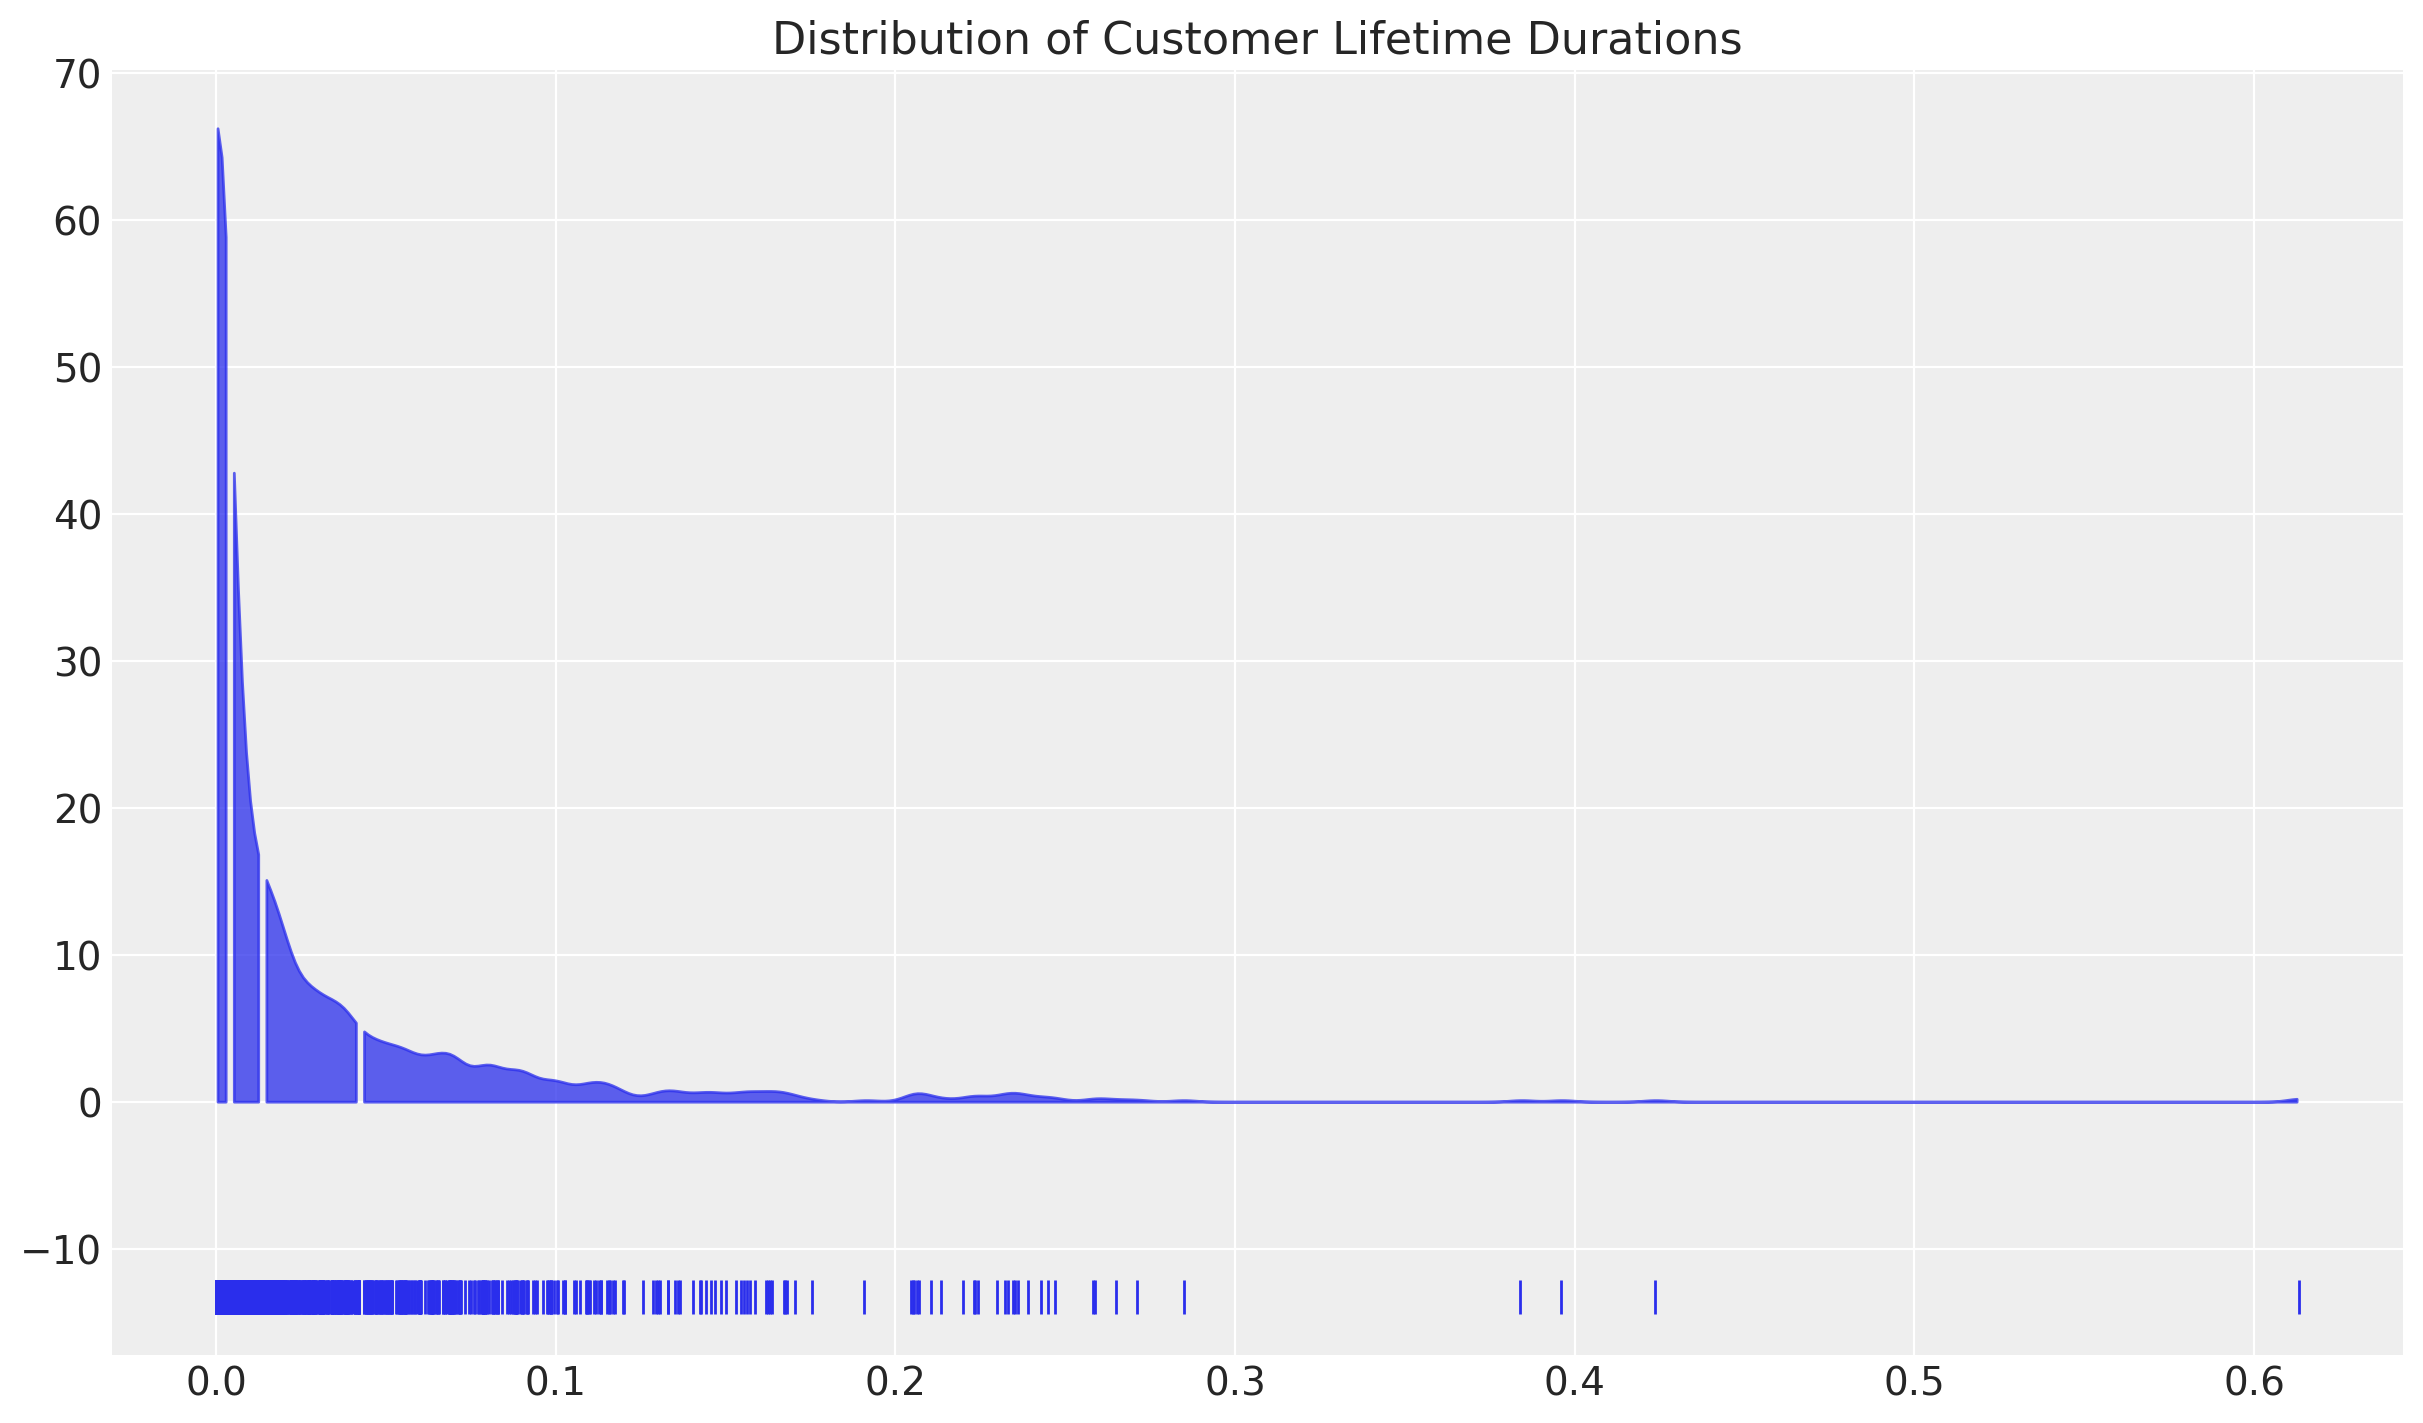

In [26]:
customer_dropout_dist = pnbd_pymc.distribution_new_customer_dropout(random_seed=45).values[0]

az.plot_dist(customer_dropout_dist, rug=True, quantiles=[.25, .5, .75]).set_title("Distribution of Customer Lifetime Durations")
print(f"Tail of Distribution: {round((1/0.6)/12,2)} weeks an active customer")
print(f"Peak of Distribution: {round((1/0.001)/12,2)} weeks an active customer")

However, the CDNOW sample dataset only represents 10% of the total data. If this happens to be a simple random sample of the customer population, the frequentist MLE approach work quite well. flat priors are perfectly fine, but this is a lofty ideal seldom encountered in practice.

Also, we can incorporate our subjective domain knowledge of the modeling use case into the model/ 

In [66]:
pnbd_pymc = clv.ParetoNBDModel(data=rfm_data)
pnbd_pymc.build_model() #optional step
print(pnbd_pymc)

Pareto/NBD
                r ~ Weibull(2, 1)
            alpha ~ Weibull(2, 10)
                s ~ Weibull(2, 1)
             beta ~ Weibull(2, 10)
recency_frequency ~ ParetoNBD(r, alpha, s, beta, <constant>)


NUTS is the default sampler, which samples from the posterior by explorong the gradients of the probability space.

In [ ]:
idata_map = pnbd_pymc.fit(fit_method='mcmc')

idata_map

Note mcmc takes an inordinate amount to time to converge. This is due to the likelihood expression containing complex gradients which may become unstable with poorly specified priors. 

In [ ]:
# add DEMetropolisZ code here

# ParetoNBD Model in `pymc_marketing`

Build models fit with both MAP and MCMC

In [3]:
model_config = {
    "r_prior": {"dist": "HalfFlat", "kwargs": {}},
    "alpha_prior": {"dist": "HalfFlat", "kwargs": {}},
    "s_prior": {"dist": "HalfFlat", "kwargs": {}},
    "beta_prior": {"dist": "HalfFlat", "kwargs": {}},
    }

map_fit = ParetoNBDModel(df)
map_fit.fit()

lt_fit = {
    'r': 0.5532631052128189,
     'alpha': 10.577412770186461,
     's': 0.6062085898176242,
     'beta': 11.668105047300301,
    }

print("MAP Fit:")
print(map_fit.fit_summary())


MAP Fit:
r         0.560
alpha    10.591
s         0.550
beta      9.756
Name: value, dtype: float64


In [4]:
map_fit = ParetoNBDModel(df)

# TODO: build_model() and fit() methods both return NoneType objects.
#pnbd.idata not yet created at this point

# pnbd.sample_prior_predictive() can be used after calling build_model and before fitting,
# it will return an xarray.Dataset, but also create the pnbd.idata arviz.InferenceData object
#map_fit.sample_prior_predictive()

# fitting the model will overwrite the prior_predictive idata object
map_fit.fit(fit_method='map')

assert map_fit.fit_result == map_fit.idata.posterior

map_fit.idata

Inference data with groups:
	> posterior
	> observed_data
	> fit_data

In [5]:
# fit same model with MCMC to compare return arviz outputs
# Note that HalFlat priors take a very long time to sample
mcmc_fit = ParetoNBDModel(df)
mcmc_fit.fit(fit_method='mcmc')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [r, alpha, s, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 249 seconds.


In [6]:
# posterior predictive checks not directly supported,
# because GammaGammaModel and BetaGeoModel use Potentials to calculate logp
with mcmc_fit.model:
    post_idata = pm.sample_posterior_predictive(mcmc_fit.idata)

mcmc_fit.idata.extend(post_idata)
mcmc_fit.idata

Sampling: [likelihood]


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> fit_data
	> posterior_predictive

In [7]:
mcmc_fit.fit_summary()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
r,0.563,0.045,0.483,0.648,0.001,0.001,1784.0,1970.0,1.0
alpha,10.694,0.823,9.216,12.239,0.019,0.013,1867.0,2129.0,1.0
s,0.598,0.115,0.402,0.821,0.003,0.002,1312.0,1645.0,1.0
beta,11.369,3.627,5.349,18.412,0.098,0.069,1347.0,1668.0,1.0


array([<Axes: title={'center': 'r'}>, <Axes: title={'center': 'alpha'}>,
       <Axes: title={'center': 's'}>, <Axes: title={'center': 'beta'}>],
      dtype=object)

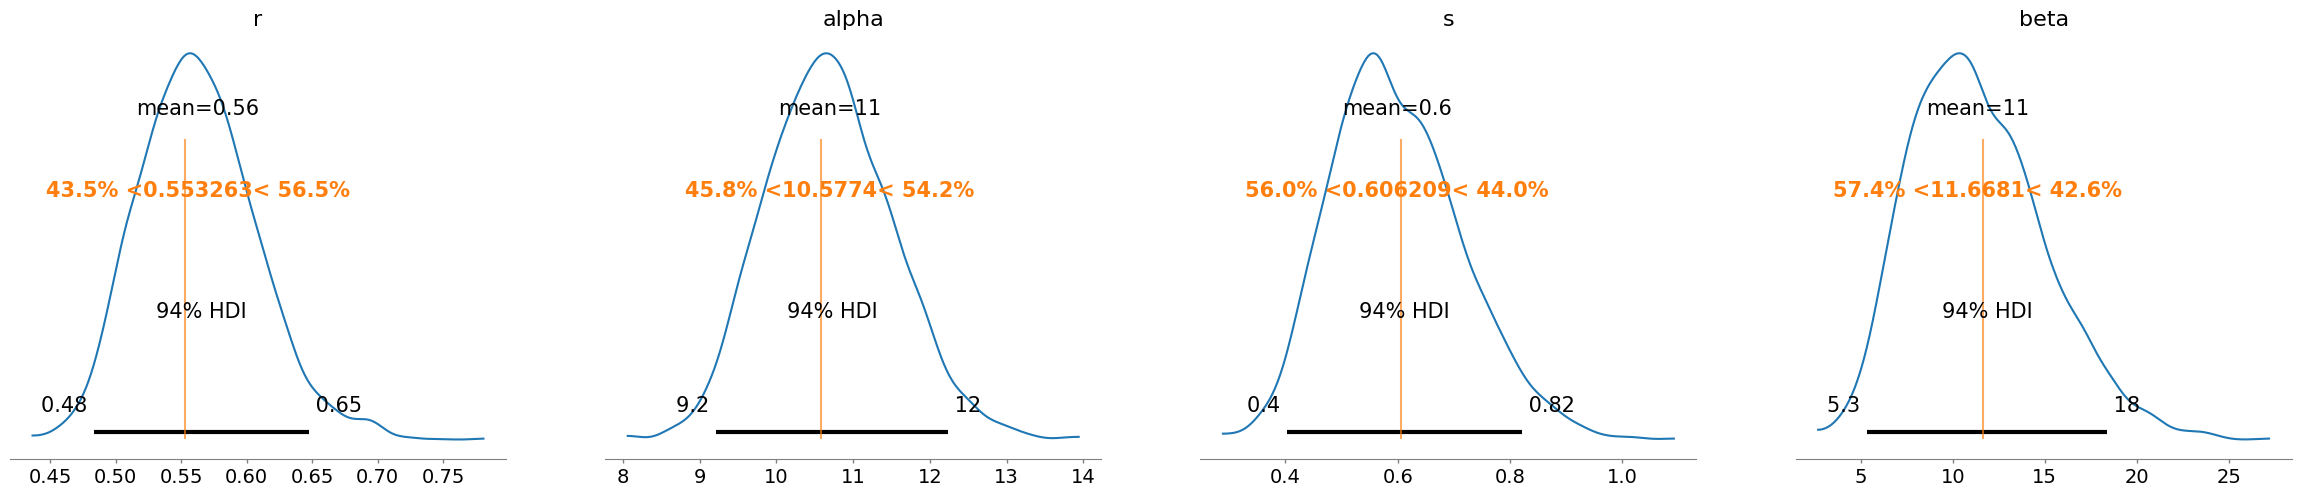

In [8]:
az.plot_posterior(mcmc_fit.idata, ref_val=list(lt_fit.values()))

In [9]:
obs_freq = mcmc_fit.idata.observed_data['likelihood'][...,1].to_pandas().value_counts().sort_index()
prior_pred_freq = mcmc_fit.idata.prior_predictive['likelihood'][0][0][...,1].to_pandas().value_counts().sort_index()

plot_prior_pred = pd.DataFrame({"prior_predictive": prior_pred_freq, "observed": obs_freq})
plot_prior_pred.plot(kind="bar", title = "Plot Prior Predictive")

AttributeError: 'InferenceData' object has no attribute 'prior_predictive'

In [ ]:
post_pred_freq = mcmc_fit.idata.posterior_predictive['likelihood'][0][0][...,1].to_pandas().value_counts().sort_index()

plot_post_pred = pd.DataFrame({"prior_predictive": post_pred_freq, "observed": obs_freq})
plot_post_pred.plot(kind="bar", title = "Plot Post Predictive")

#az.plot_dist(post_idata.posterior_predictive)

In [ ]:
obs_freq_array = mcmc_fit.idata.observed_data['likelihood'][...,1]
prior_pred_freq_array = mcmc_fit.idata.prior_predictive['likelihood'][0][0][...,1]

az.plot_ecdf(prior_pred_freq_array, obs_freq_array, confidence_bands = True, difference=True).set_title("Prior Predictive Difference Plot")
az.plot_ecdf(prior_pred_freq_array, obs_freq_array, confidence_bands = True).set_title("Prior Predictive ECDF Plot")

In [ ]:
obs_freq_array = mcmc_fit.idata.observed_data['likelihood'][...,1]
post_pred_freq_array = mcmc_fit.idata.posterior_predictive['likelihood'][0][0][...,1]

az.plot_ecdf(post_pred_freq_array, obs_freq_array, confidence_bands = True, difference=True).set_title("Posterior Predictive Difference Plot")
az.plot_ecdf(post_pred_freq_array, obs_freq_array, confidence_bands = True).set_title("Posterior Predictive ECDF Plot")

https://python.arviz.org/en/stable/api/generated/arviz.plot_ecdf.html#arviz.plot_ecdf

# Plot the `ParetoNBDModel` Dropout and Purchase Rate Distributions for New Customers

In [10]:
customer_dropout_mcmc = mcmc_fit.distribution_new_customer_dropout()
customer_purchase_rate_mcmc = mcmc_fit.distribution_new_customer_purchase_rate()
customer_population_mcmc = mcmc_fit.distribution_customer_population()

customer_dropout_map = map_fit.distribution_new_customer_dropout()
customer_purchase_rate_map = map_fit.distribution_new_customer_purchase_rate()
customer_population_map = map_fit.distribution_customer_population()

Sampling: [population_dropout]


Sampling: [population_purchase_rate]


Sampling: [customer_population]


Sampling: [population_dropout]


Sampling: [population_purchase_rate]


Sampling: [customer_population]


In [30]:
customer_dropout_mcmc.shape

#(1, 1, 2357, 2)
#(4, 1000, 2357, 2)

(4, 1000)

In [23]:
N = 2357
chains = 2
draws = 50

rng = np.random.default_rng(34)

mock_idata = az.from_dict(
    {
        "r": rng.normal(0.55, 1e-3, size=(chains, draws)),
        "alpha": rng.normal(
           10.56, 1e-3, size=(chains, draws)
        ),
        "s": rng.normal(.68, 1e-3, size=(chains, draws)),
        "beta": rng.normal(
            11.68, 1e-3, size=(chains, draws)
        ),
    }
)

mock_idata = az.from_dict(
                {
                    "r": .55,
                    "alpha": 10.56,
                    "s": .68,
                    "beta": 11.68,
                }
            )


fake_model = ParetoNBDModel(df)
fake_model.idata=mock_idata

fake_model.distribution_customer_population(T=np.tile(100,1000))

# obs_freq = mcmc_fit.idata.observed_data['likelihood'][...,1].to_pandas().value_counts().sort_index()
# prior_pred_freq = mcmc_fit.idata.prior_predictive['likelihood'][0][0][...,1].to_pandas().value_counts().sort_index()

# plot_prior_pred = pd.DataFrame({"prior_predictive": prior_pred_freq, "observed": obs_freq})
# plot_prior_pred.plot(kind="bar", title = "Plot Prior Predictive")

Sampling: [customer_population]


Inference data with groups:
	> posterior

Text(0.5, 1.0, 'Customer Dropout Distribution')

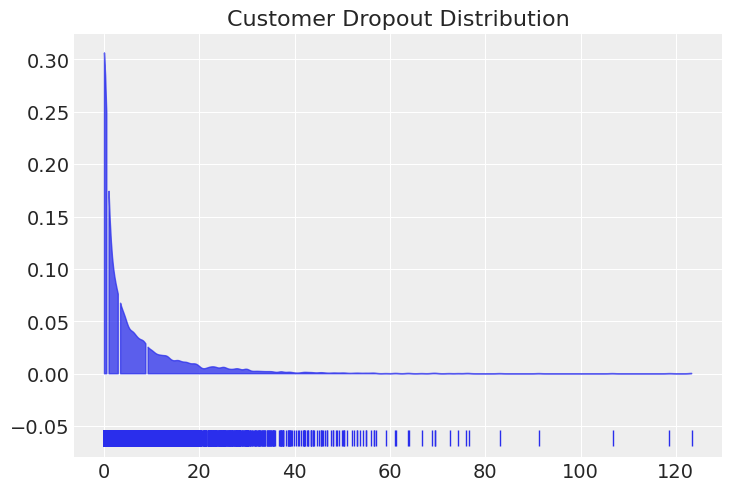

In [111]:
az.plot_dist(customer_dropout_mcmc, rug=True, quantiles=[.25, .5, .75], cumulative=False).set_title("Customer Dropout Distribution")

Text(0.5, 1.0, 'Customer Dropout Rate Distribution w/ MAP Fit')

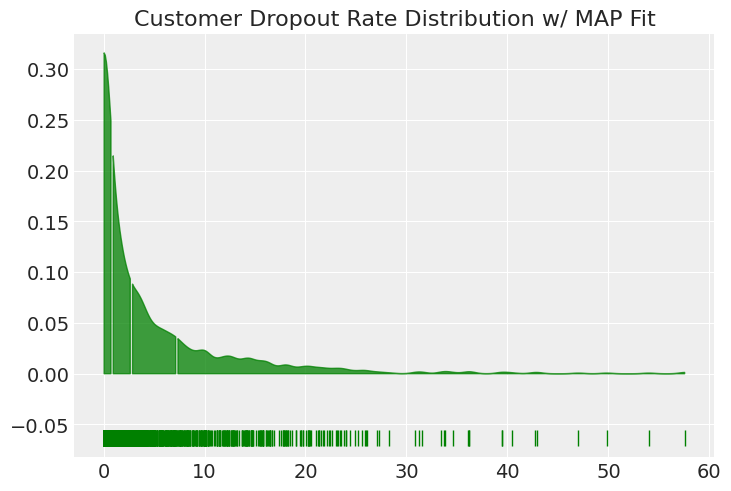

In [112]:
# Note the array indexing required for MAP fit plotting
az.plot_dist(customer_dropout_map[0][0], rug=True, color='g', quantiles=[.25, .5, .75], cumulative=False).set_title("Customer Dropout Rate Distribution w/ MAP Fit")

In [34]:
obs_freq = mcmc_fit.idata.observed_data['likelihood'][...,1].to_pandas().value_counts().sort_index()
#prior_pred_freq = mcmc_fit.idata.prior_predictive['likelihood'][0][0][...,1].to_pandas().value_counts().sort_index()
customer_population_map

# actual_counts = pd.Series(x).value_counts().sort_index()
# simulated_counts = pd.Series(model_freq).value_counts().sort_index()

# plot_prior_pred = pd.DataFrame({"prior_predictive": prior_pred_freq, "observed": obs_freq})
# plot_prior_pred.plot(kind="bar", title = "Plot Prior Predictive")

<xarray.DataArray 'customer_population' (chain: 4, draw: 1000,
                                         customer_population_dim_2: 2357,
                                         customer_population_dim_3: 2)>
array([[[[ 0.        ,  0.        ],
         [ 0.        ,  0.        ],
         [ 0.        ,  0.        ],
         ...,
         [ 0.        ,  0.        ],
         [ 0.        ,  0.        ],
         [ 0.        ,  0.        ]],

        [[ 0.        ,  0.        ],
         [33.22348507,  3.        ],
         [17.78219702,  5.        ],
         ...,
         [ 0.        ,  0.        ],
         [ 0.        ,  0.        ],
         [15.12256784,  1.        ]],

        [[36.55367967,  5.        ],
         [30.82568583,  2.        ],
         [ 0.        ,  0.        ],
         ...,
...
         ...,
         [ 0.        ,  0.        ],
         [19.43196482,  3.        ],
         [ 0.        ,  0.        ]],

        [[36.3525494 ,  6.        ],
         [ 0.        ,  0.        ],
         [38.4767482 , 12.        ],
         ...,
         [ 0.        ,  0.        ],
         [ 0.        ,  0.        ],
         [26.8154956 , 10.        ]],

        [[ 0.        ,  0.        ],
         [33.953614  ,  7.        ],
         [19.74782928,  5.        ],
         ...,
         [ 0.        ,  0.        ],
         [ 6.49108868,  1.        ],
         [13.13369364,  4.        ]]]])
Coordinates:
  * chain                      (chain) int64 0 1 2 3
  * draw                       (draw) int64 0 1 2 3 4 5 ... 995 996 997 998 999
  * customer_population_dim_2  (customer_population_dim_2) int64 0 1 ... 2356
  * customer_population_dim_3  (customer_population_dim_3) int64 0 1

# Prior Predictive Plots for the Latent Dropout and Purchase Rate Distributions  are doable, but not directly supported. It's also important to know that since both distributions have identical Priors, there is no difference in plotting between them.

array([[<Axes: title={'center': 'x'}>]], dtype=object)

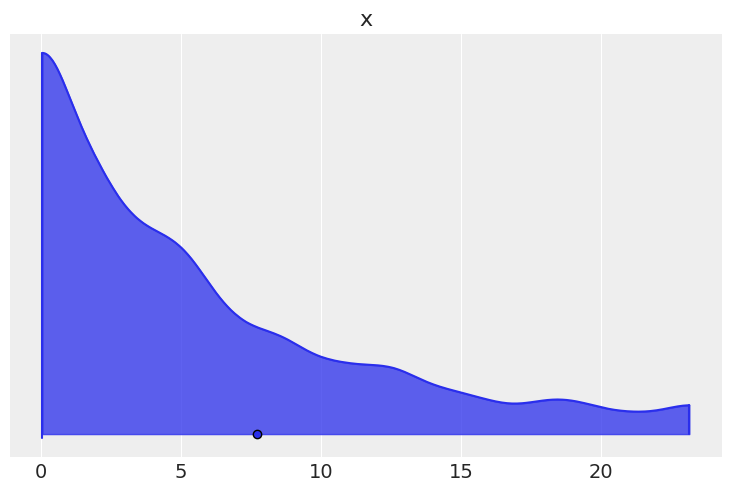

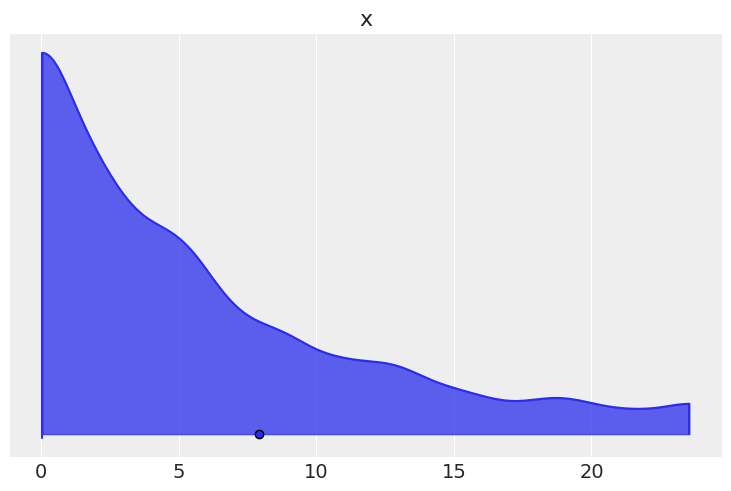

In [204]:
r_prior = mcmc_fit.idata.prior["r"]
alpha_prior = mcmc_fit.idata.prior["alpha"]
s_prior = mcmc_fit.idata.prior["s"]
beta_prior = mcmc_fit.idata.prior["beta"]

purchase_rate_dist = pm.draw(
    pm.Gamma.dist(
        alpha=r_prior.values[..., None].mean(),
        beta=1 / alpha_prior.values[..., None].mean(),
        shape=1000,
    ),
    random_seed=42)

dropout_rate_dist = pm.draw(
    pm.Gamma.dist(
        alpha=s_prior.values[..., None].mean(),
        beta=1 / beta_prior.values[..., None].mean(),
        shape=1000,
    ),
    random_seed=42)

az.plot_density(purchase_rate_dist,point_estimate="mean", shade=.75)
az.plot_density(dropout_rate_dist,point_estimate="mean", shade=.75)

# Predictive Methods for `ParetoNBDModel`

In [24]:
pnbd_map.save('pnbd.nc')
pnbd_map.load('pnbd.nc')

# Append all predictive methods to a pandas dataframe
#df['exp_prchs_mcmc'] = pnbd_mcmc.expected_purchases(future_t = 10).mean(("chain", "draw"))
df['exp_prchs_map'] = pnbd_map.expected_purchases(future_t = 10).mean(("chain", "draw"))

#df['prob_alive_mcmc'] = pnbd_mcmc.expected_probability_alive(future_t = 10).mean(("chain", "draw"))
df['prob_alive_map'] = pnbd_map.expected_probability_alive(future_t = 10).mean(("chain", "draw"))

#df['prchs_prob_mcmc'] = pnbd_mcmc.expected_purchase_probability(n_purchases=3,future_t=30).mean(("chain", "draw"))
df['prchs_prob_map'] = pnbd_map.expected_purchase_probability(n_purchases=3,future_t=30).mean(("chain", "draw"))

# This value does not change from customer to customer, but is shown here for completeness
#df['new_customer_mcmc'] = pnbd_mcmc.expected_purchases_new_customer(t = 100).mean().values
df['new_customer_map'] = pnbd_map.expected_purchases_new_customer(t = 100).mean().values

# For single customer predictions, arguments must still be provided as lists or numpy arrays
# Array lengths must match for all arguments
# pnbd_mcmc.expected_purchases(future_t = 10,
#                              customer_id = [1000],
#                              frequency = np.array([3]),
#                              recency = [20],
#                              T = [30]).mean(("chain", "draw"))

# # Use a for loop or list comprehension to iterate over multiple arguments:
# [pnbd_mcmc.expected_purchases(future_t = t) for t in [10,9,8]]

df.head(10)

/Users/coltallen/miniconda3/envs/pymc-dev/lib/python3.8/site-packages/arviz/data/inference_data.py:152: UserWarning: fit_data group is not defined in the InferenceData scheme
  warnings.warn(
/Users/coltallen/Projects/pymc-marketing/pymc_marketing/clv/models/pareto_nbd.py:175: UserWarning: The Pareto/NBD model is still experimental. Please see code examples in documentation if model fitting issues are encountered.
  warnings.warn(


,frequency,recency,T,monetary_value,customer_id,exp_prchs_mcmc,exp_prchs_map,prob_alive_mcmc,prob_alive_map,prchs_prob_map,new_customer_map
0,2,30.43,38.86,22.35,0,0.426163,0.429898,0.781540,0.789804,0.082505,2.257801
1,1,1.71,38.86,11.77,1,0.049964,0.050083,0.150524,0.151008,0.008571,2.257801
2,0,0.00,38.86,0.00,2,0.031313,0.031521,0.263049,0.264870,0.003761,2.257801
3,0,0.00,38.86,0.00,3,0.031313,0.031521,0.263049,0.264870,0.003761,2.257801
4,0,0.00,38.86,0.00,4,0.031313,0.031521,0.263049,0.264870,0.003761,2.257801
5,7,29.43,38.86,73.74,5,1.087263,1.102017,0.675588,0.685516,0.110536,2.257801
6,1,5.00,38.86,11.77,6,0.076542,0.077453,0.230524,0.233532,0.013254,2.257801
7,0,0.00,38.86,0.00,7,0.031313,0.031521,0.263049,0.264870,0.003761,2.257801
8,2,35.71,38.86,25.55,8,0.469376,0.471763,0.860708,0.866718,0.090540,2.257801
9,0,0.00,38.86,0.00,9,0.031313,0.031521,0.263049,0.264870,0.003761,2.257801
